# **Projeto Big Data - 2s2024**
## **Desenvolvido por:**
- Cesar Ezra Ades
- Jonathan Sutton
- Uri Muszkat


### Introdução
Este conjunto de dados do Estado de Connecticut contém registros de vendas de imóveis ocorridas entre 2001 e 2022, com valores iguais ou superiores a $2.000. Os dados incluem informações sobre a cidade, endereço, data da venda, tipo de propriedade (residencial, apartamento, comercial, industrial ou terreno vazio), preço de venda e avaliação do imóvel. As vendas são relatadas para o ano fiscal de outubro a setembro de cada ano, em conformidade com as leis estaduais de Connecticut, sendo uma fonte importante para análises de mercado e estatísticas de transações imobiliárias na região.

### Objetivo
O objetivo do projeto é realizar uma análise exploratória dos dados disponíveis. A análise buscará identificar padrões de preços, variações sazonais e tendências de mercado por tipo de propriedade e localização, oferecendo insights para o setor imobiliário e planejadores urbanos.

In [0]:
#Abrindo a base de dados

import pyspark.sql.functions as func

url = "s3://bigdata-rais/projeto/jonathans/real_estate_sales_2001_2022_gl.csv"

df = spark.read.csv(url,header=True)
df.limit(2).display()




Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
220008,2022,01/30/2023,Andover,618 ROUTE 6,139020.00,232000.00,0.5992,Residential,Single Family,null,null,null,POINT (-72.343628962 41.728431984)
2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.00,325000.00,0.463,Commercial,null,null,null,null,null


In [0]:
print(f'Esse df tem {df.count()} linhas')
df.columns

Esse df tem 1097629 linhas


['Serial Number',
 'List Year',
 'Date Recorded',
 'Town',
 'Address',
 'Assessed Value',
 'Sale Amount',
 'Sales Ratio',
 'Property Type',
 'Residential Type',
 'Non Use Code',
 'Assessor Remarks',
 'OPM remarks',
 'Location']

In [0]:
colunas_para_remover = ['Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location']

# Removendo as que não serão úteis
df = df.drop(*colunas_para_remover)
df = df.limit(100000) #500.000 linhas - para rodar as células
df.limit(2).display()


Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type
220008,2022,01/30/2023,Andover,618 ROUTE 6,139020.00,232000.00,0.5992,Residential,Single Family
2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.00,325000.00,0.463,Commercial,null


Tabela contendo número de propriedades por tipologia e média de preço de venda.

In [0]:
from pyspark.sql import functions as F

# Supondo que o DataFrame df já esteja carregado com os dados
property_type_summary = df.groupBy("Property Type").agg(
    F.count("Sale Amount").alias("Contagem"),
    F.mean("Sale Amount").alias("Media_Sale_Amount")
).orderBy("Contagem", ascending=False)

# Exibir o resumo
property_type_summary.show(truncate=False)



+--------------+--------+------------------+
|Property Type |Contagem|Media_Sale_Amount |
+--------------+--------+------------------+
|Residential   |90465   |478742.0799522468 |
|Vacant Land   |4749    |294247.61509791535|
|Commercial    |3306    |1665524.251170599 |
|Apartments    |755     |8997454.646357616 |
|Industrial    |427     |2168835.566744731 |
|NULL          |291     |261768.3298969072 |
|Public Utility|7       |272292.0          |
+--------------+--------+------------------+




Como é possível ver na tabela acima, o tipo de propriedade mais negociada no período foi as do tipo 'Residential', com 90.465 imóveis negociados. Ao mesmo tempo, podemos observar que os imóveis com a maior média de preço de venda foram imóveis Residenciais, com uma média de U$478.742,09 por imóvel.

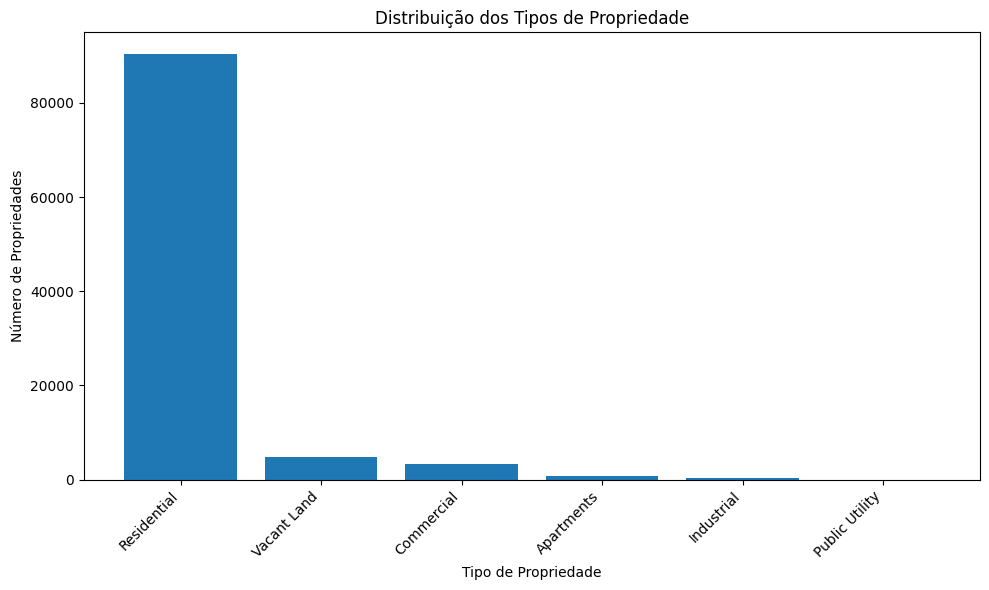

In [0]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

property_count = (
    df.groupBy("Property Type")
    .agg(F.count("*").alias("Count"))
    .orderBy("Count", ascending=False)
)

data = property_count.collect()
property_types = [row["Property Type"] for row in data if row["Property Type"] is not None]
counts = [row["Count"] for row in data if row["Property Type"] is not None]  # Filtra para manter alinhamento

plt.figure(figsize=(10, 6))
plt.bar(property_types, counts)
plt.title("Distribuição dos Tipos de Propriedade")
plt.xlabel("Tipo de Propriedade")
plt.ylabel("Número de Propriedades")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()


## Relação entre Preço de Venda e Valor Avaliado

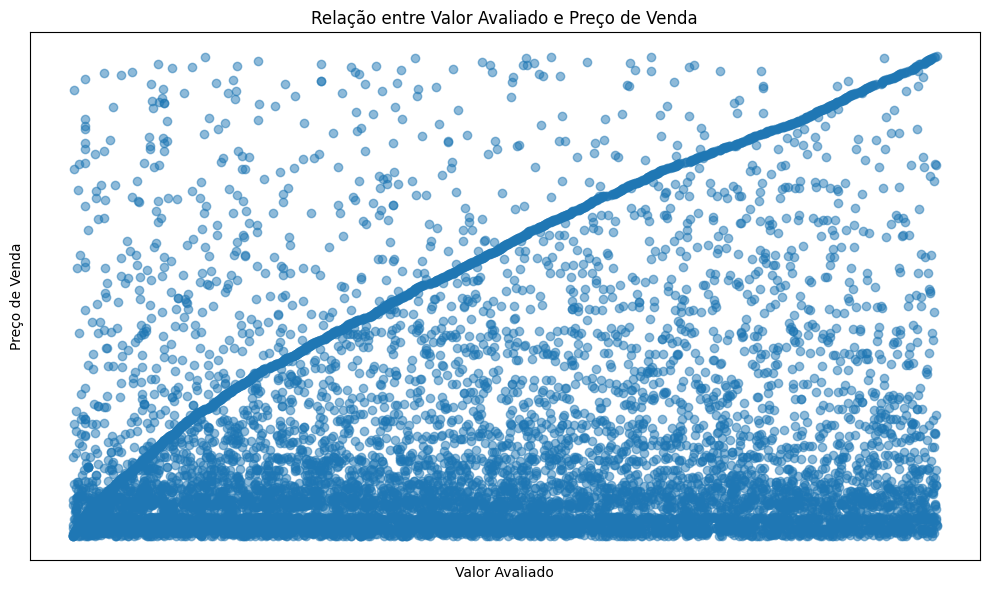

In [0]:
scatter_data = df.select("Sale Amount", "Assessed Value").limit(10000).collect()  
sale_amount = [row["Sale Amount"] for row in scatter_data]
assessed_value = [row["Assessed Value"] for row in scatter_data]

plt.figure(figsize=(10, 6))
plt.scatter(assessed_value, sale_amount, alpha=0.5)

plt.xticks([])  
plt.yticks([])  

plt.title("Relação entre Valor Avaliado e Preço de Venda")
plt.xlabel("Valor Avaliado")
plt.ylabel("Preço de Venda")

# Adicionar grade para maior clareza
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

É possível observar, a partir do gráfico:
- Correlação Positiva: Existe uma relação positiva clara entre o valor avaliado e o preço de venda. Conforme o valor avaliado aumenta, o preço de venda também tende a aumentar.]
- Ruído na parte inferior: Há muitos dados concentrados em valores baixos, o que pode indicar um padrão consistente ou outliers com valores baixos de avaliação e venda.
- Linha de tendência evidente: O padrão geral segue uma linha crescente.

### Total de vendas por cidade

In [0]:
city_summary = (
    df.groupBy("Town")
    .agg(F.count("*").alias("Total Sales"))
    .orderBy("Total Sales", ascending=False)
    .limit(10)
)

city_summary.show(truncate=False)

+-----------+-----------+
|Town       |Total Sales|
+-----------+-----------+
|Danbury    |2951       |
|Bridgeport |2779       |
|Stamford   |2698       |
|Bristol    |2575       |
|Waterbury  |2395       |
|New Britain|2298       |
|Greenwich  |2271       |
|Norwalk    |1943       |
|New Haven  |1890       |
|Middletown |1834       |
+-----------+-----------+



É possível observar que a cidade de Danbury possui o maior número de vendas de imóveis.

A análise abaixo apresenta o resumo estatístico das colunas **`Sale Amount`** (Preço de Venda) e **`Assessed Value`** (Valor Avaliado). Esses dados oferecem uma visão geral das distribuições de ambas as variáveis.


In [0]:
numerical_summary = df.select("Sale Amount", "Assessed Value").describe()
numerical_summary.show(truncate=False)

+-------+--------------------+------------------+
|summary|Sale Amount         |Assessed Value    |
+-------+--------------------+------------------+
|count  |100000              |100000            |
|mean   |580102.5903435      |322446.96325      |
|stddev |1.5988619809183106E7|1661493.0294004483|
|min    |0.00                |0.00              |
|max    |999999.00           |99990.00          |
+-------+--------------------+------------------+



O resumo estatístico mostra que o número total de registros disponíveis para análise é de 100.000, representando uma amostra significativa. A média do Preço de Venda (Sale Amount) é de aproximadamente $580.102, enquanto o Valor Avaliado (Assessed Value) apresenta uma média de $322.446, indicando que, em média, as propriedades foram vendidas por valores superiores ao avaliado.


## Conclusão

A análise exploratória dos dados de vendas imobiliárias de Connecticut entre 2001 e 2022 revelou insights importantes sobre o mercado local. Observou-se uma forte relação positiva entre o valor avaliado e o preço de venda das propriedades, indicando que valores avaliados mais altos geralmente resultam em preços de venda mais elevados. Além disso, propriedades residenciais dominaram em quantidade, enquanto propriedades comerciais apresentaram os preços médios mais altos.

Os dados também mostraram uma diferença significativa entre o valor avaliado e o preço de venda, sugerindo que outros fatores, como localização e condições de mercado, podem influenciar significativamente os preços. No geral, o projeto forneceu uma base sólida para entender as tendências do mercado imobiliário em Connecticut e pode ser utilizado para informar planejadores urbanos, investidores e outros interessados no setor.





